**Business Problem:** I have a AWS Glue job that I would like to run continuously. This Glue job can be invoked by an existing Lambda function. I would like to create a rule that will re-invoke that Lambda function as soon a the prior Glue job has concluded. 

In AWS CLI, I could manually start the Glue job by running the following:
    
        aws glue start-job-run --job-name "Leed Feed - Web Forms"

Additionally, I can run the below to invoke the Lambda function that would initiate the Glue job:

        aws lambda invoke --function-name leedfeed_webforms_glue response.json

In order to get this Glue job to run continuously, I will need to utilize the Lambda function path in order to trigger the Glue job. The below does this by simply initiating the Glue job:

        import boto3, json

        def lambda_handler(event, context):
                glue_client = boto3.client('glue')
                job_name = 'Leed Feed - Web Forms'
                response = glue_client.start_job_run(JobName=job_name)
                
                return {
                'statusCode': 200,
                'body': json.dumps('Glue job has been initiated')
                }

How can I utilize this concept to make the Glue job run continuously?

**Solution:**
- Go to *Amazon EventBridge* and select *Rules* under the *Buses* header in the left-panel menu and select the *Create rule* option.
- Give the rule a *Name* and optional *Description*.
- Deselect the *Enable the rule on the selected event bus* option.
- Select the *Rule with an event pattern* under the *Rule type* option and the select *Next*.

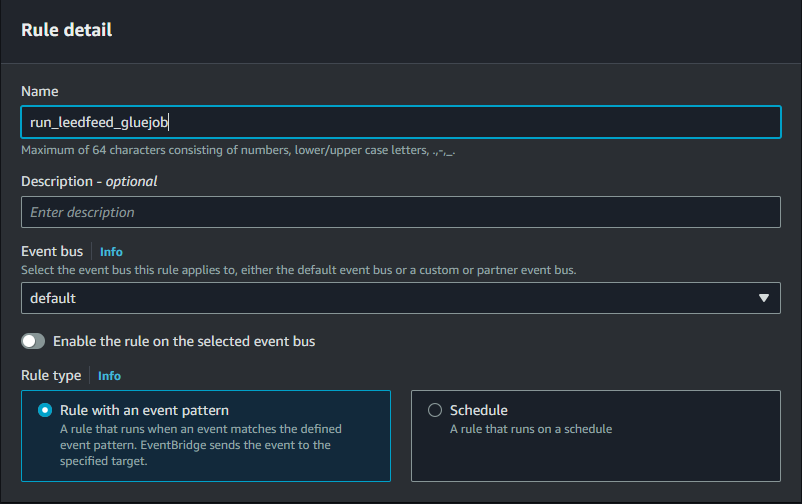

- Select the *Event source* as *Other*.
- You can use the *Sample event* feature to develop a template for your use case.
- Scroll down and under the *Creation method* section, select *Custom pattern (JSON editor)*.
- Input the below code under the *Event pattern*:

        {
        "source": ["aws.glue"],
        "detail-type": ["Glue Job State Change"],
        "detail": {
            "state": ["SUCCEEDED", "FAILED", "TIMEOUT", "STOPPED"],
            "jobName": ["Leed Feed - Web Forms"]
        }
        }

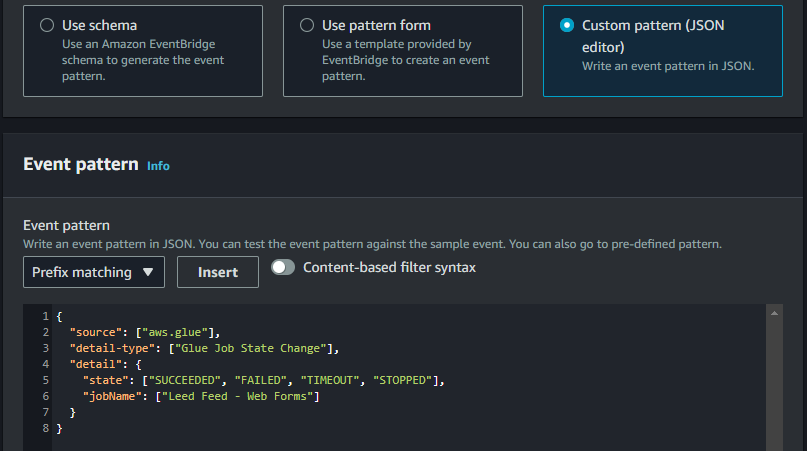

- Select *Next*.
- Select *AWS service* under the *Target 1* section and select *Lambda function* for *Select a target* and in this case *leedfeed_webforms_glue* under the *Function* input.

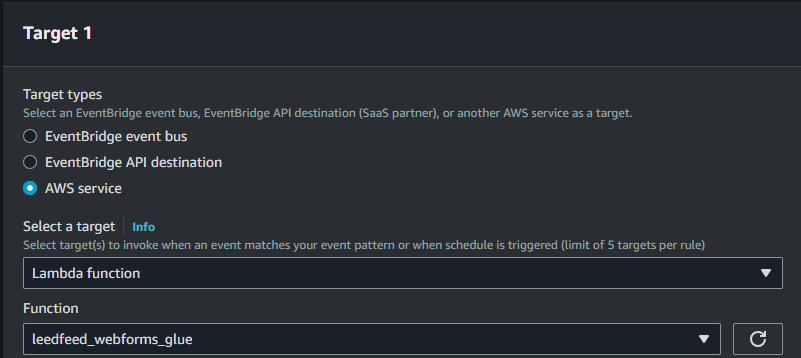

- Select *Next*.
- Skip the *Configuration tags* and select *Next*.
- Review the final output and then select *Create rule*.

The rule might not be enabled as a default. To enable, click the selector and then press the *Enable* button. This would be the same method for *Disable* an rule as well.

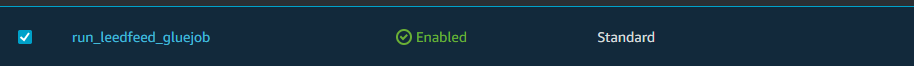

Now this won't activate the first instance so you will need to manually invoke the first Glue job and once that first job completes it should pick up the continuous runs from there. This is because the Lambda jobs is triggered by the Glue jobs state change to one of the options mentioned in the Lambda function shown above. Initializing the first run can be done manually in the AWS Glue console by selecting *Run* option or by using the CLI as mentioned previously.

To check on the status, go to the AWS Glue console and either go to the particular Glue Notebook and go to the *Runs* option to see the status or go to the *Job run monitoring* option, both under the *ETL jobs* header of the left-panel.

- Option 1:

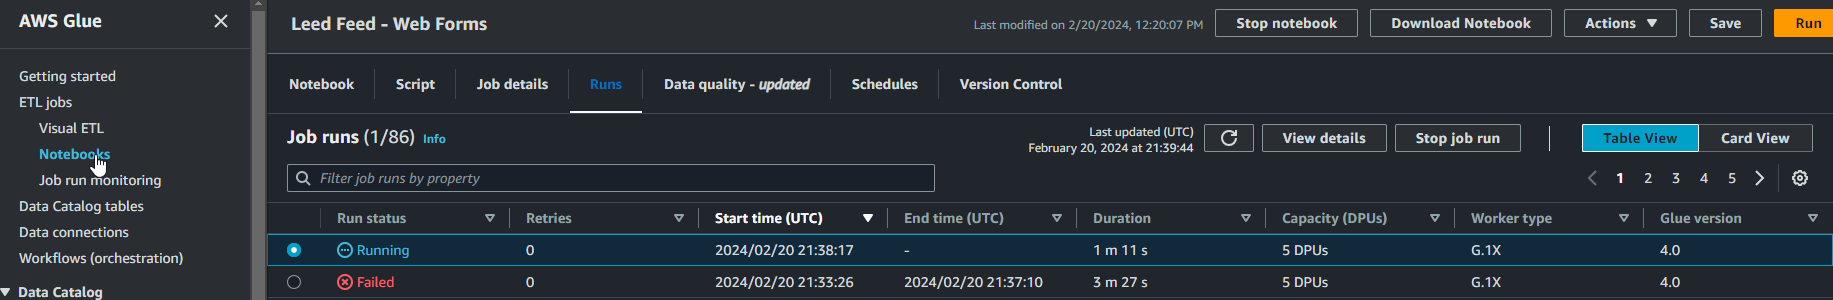

- Option 2:

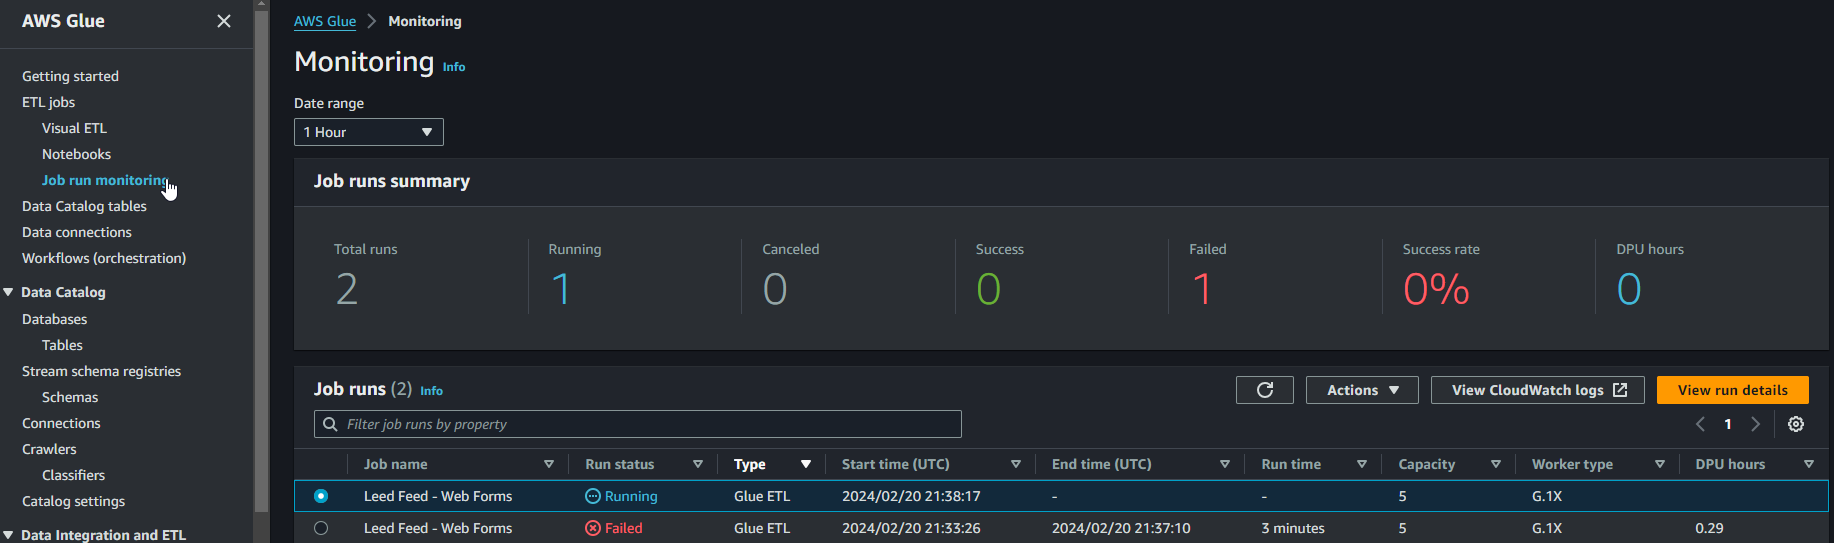

In this case, the first run failed due to a designed failure point that exists in the execution of the script:



It can be seen that the EventBridge saw this failure and invoked the next instance of the Glue job using the Lambda function.

IMPORTANT! In the *Job run monitoring* menu, mentioned above, there is a field called *DPU hours* depicted in the Job runs output table. This should be closely monitored and evaluated as this is the value that determines the cost associated with the run. Running continuous Glue jobs can have significant cost associated with it and should only be done so with the approval of leadership and the absence of other methods.


